In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

# test for new prior function - redshift prior is basically set by observed line width 

#spec_wobs = norm(loc=3.,scale=0.05)

#xrange = np.linspace(2.,4.,100)

#pobs = spec_wobs.pdf(xrange)

#plt.plot(xrange,pobs)
#plt.show()

# halpha rest wavelength is 0.65

##rest = 0.65 

#pz = (pobs/rest)-1.

#plt.plot(xrange,pz)
#plt.show()

rest = 0.65 
pl = np.random.normal(loc=3.,scale=0.05,size=1000)

plt.hist(pl,histtype='step',bins=np.arange(2.5,3.5,0.01))
plt.show()

pz = (pl/rest)-1.

plt.hist(pz,histtype='step')
plt.show()


In [ ]:
nsamp = 64
xline = np.linspace(-nsamp, nsamp, 2*nsamp+1)/nsamp*0.1+1
yline = xline*0.
yline[nsamp] = 1
yline /= np.trapz(yline, xline)

In [ ]:
plt.plot(xline,yline)

In [ ]:
print(nsamp*0.1+1)

In [ ]:
print(xline)

In [ ]:
print(np.trapz(yline, xline))

In [ ]:
import os
from grizli import utils

In [ ]:
def resample_template_numba(spec_wobs, spec_R_fwhm, templ_wobs, templ_flux, velocity_sigma=100, nsig=5, fill_value=0.):
    """
    Resample a high resolution template/model on the wavelength grid of a
    spectrum with (potentially) wavelength dependent dispersion
    
    Parameters
    ----------
    spec_wobs : array-like
        Spectrum wavelengths
    
    spec_R_fwhm : array-like
        Spectral resolution `wave/d(wave)`, FWHM
    
    templ_wobs : array-like
        Template wavelengths, observed frame.  Same units as `spec_wobs`.  
        **NB:** both `spec_wobs` and `templ_wobs` assumed to be sorted!
    
    templ_flux : array-like
        Template flux densities sampled at `templ_wobs`
    
    velocity_sigma : float
        Kinematic velocity width, km/s
    
    nsig : float
        Number of sigmas of the Gaussian convolution kernel to sample
    
    Returns
    -------
    resamp : array-like
        Template resampled at the `spec_wobs` wavelengths, convolved with a 
        Gaussian kernel with sigma width
        
        >>> Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
        >>> dw = spec_wobs / Rw
    
    """    
    dw = np.sqrt((velocity_sigma/3.e5)**2 + (1./2.35/spec_R_fwhm)**2)*spec_wobs
    
    #Rw = 1./np.sqrt((velocity_sigma/3.e5)**2 + 1./(spec_R_fwhm*2.35)**2)
    # dw = spec_wobs / Rw
    
    ilo = 0
    ihi = 1
    
    N = len(spec_wobs)
    resamp = np.zeros_like(spec_wobs)*fill_value
    
    Nt = len(templ_wobs)
    
    for i in range(N):
        #sl = slice(ilo[i], ihi[i])
        while (templ_wobs[ilo] < spec_wobs[i]-nsig*dw[i]) & (ilo < Nt-1):
            ilo += 1
        
        if ilo == 0:
            continue
            
        ilo -= 1
        
        while (templ_wobs[ihi] < spec_wobs[i]+nsig*dw[i]) & (ihi < Nt):
            ihi += 1
        
        if (ilo >= ihi):
            resamp[i] = templ_flux[ihi]
            continue
        elif (ilo == Nt-1):
            break
            
        sl = slice(ilo, ihi)
        lsl = templ_wobs[sl]
        g = np.exp(-(lsl-spec_wobs[i])**2/2/dw[i]**2)/np.sqrt(2*np.pi*dw[i]**2)
        # g *= 1./np.sqrt(2*np.pi*dw[i]**2) 
        resamp[i] = np.trapz(templ_flux[sl]*g, lsl)
        
    return resamp

In [ ]:
res = self.resample_func(spec_wobs,
                                 spec_R_fwhm*scale_disp, 
                                 self.xline*line_um,
                                 self.yline,
                                 velocity_sigma=velocity_sigma,
                                 nsig=nsig)

In [2]:
import data
import os

msaexp version = 0.6.9
numpy version = 1.23.5


In [3]:

test = data.Data(spectrum_file=os.path.abspath('../test_data/macs0417.1208_340.v0.spec.fits'),photometry_file=None,run_ID=1,phot_id=None)

spec1d found
Reading in spectrum with grating prism/clear combination
No photometry found


In [6]:
test.spec_fnu

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.17572327,  0.15336145,  0.18460391,
        0.23012993,  0.28905913,  0.29652712,  0.2690856 ,  0.283257  ,
        0.32154623,  0.33469117,  0.3696483 ,  0.3868451 ,  0.44534287,
        0.4477027 ,  0.45536223,  0.5063964 ,  0.51536393,  0.49446452,
        0.54499245,  0.56930804,  0.6258007 ,  0.64080065,  0.65835893,
        0.66499215,  0.71782726,  0.73695797,  0.7375102 ,  0.80516523,
        0.9158398 ,  1.0523053 ,  1.1748568 ,  1.1732209 ,  1.3004771 ,
        1.3529545 ,  1.3741347 ,  1.4067327 ,  1.4903766 ,  1.5593704 ,
        1.6134467 ,  1.6262648 ,  1.7154367 ,  1.7527344 ,  1.7957207 ,
        1.84026   ,  1.8412802 ,  1.8329778 ,  1.8970834 ,  1.9236703 ,
        1.9500153 ,  1.9932832 ,  2.0105572 ,  2.1612906 ,  2.2104044 ,
        2.2125344 ,  2.2777584 ,  2.3481982 ,  2.4041266 ,  2.5258234 ,
        2.6546183 ,  2.7390873 ,  2.9868345 ,  3.0133734 ,  2.88

In [3]:
spec = test.initialize_spec()

spec1d found
Reading in spectrum with grating prism/clear combination


In [4]:
test

In [5]:
test.spec_wobs

array([0.55303764, 0.5630819 , 0.5731262 , 0.5831705 , 0.59321475,
       0.603259  , 0.6133033 , 0.6233476 , 0.63339186, 0.64343613,
       0.6534804 , 0.6635247 , 0.67356896, 0.68361324, 0.6936575 ,
       0.7037018 , 0.7137461 , 0.72379035, 0.7338346 , 0.7438789 ,
       0.7539232 , 0.76396745, 0.77401173, 0.784056  , 0.7941003 ,
       0.80414456, 0.81418884, 0.8242331 , 0.83427745, 0.8443217 ,
       0.854366  , 0.8644103 , 0.87445456, 0.88449883, 0.8945431 ,
       0.9045874 , 0.91463166, 0.92467594, 0.9347202 , 0.9447645 ,
       0.9548088 , 0.96485305, 0.9748973 , 0.9849416 , 0.9949859 ,
       1.0050302 , 1.0150745 , 1.0251187 , 1.035163  , 1.0452073 ,
       1.0552516 , 1.0652958 , 1.0753402 , 1.0853844 , 1.0954287 ,
       1.1054729 , 1.1155173 , 1.1255615 , 1.1356058 , 1.14565   ,
       1.1556944 , 1.1657386 , 1.1757829 , 1.1858271 , 1.1958715 ,
       1.2059157 , 1.21596   , 1.2260042 , 1.2360486 , 1.2460928 ,
       1.2561371 , 1.2661813 , 1.2762257 , 1.28627   , 1.29631

In [7]:
test.spec_fnu

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.17572327,  0.15336145,  0.18460391,
        0.23012993,  0.28905913,  0.29652712,  0.2690856 ,  0.283257  ,
        0.32154623,  0.33469117,  0.3696483 ,  0.3868451 ,  0.44534287,
        0.4477027 ,  0.45536223,  0.5063964 ,  0.51536393,  0.49446452,
        0.54499245,  0.56930804,  0.6258007 ,  0.64080065,  0.65835893,
        0.66499215,  0.71782726,  0.73695797,  0.7375102 ,  0.80516523,
        0.9158398 ,  1.0523053 ,  1.1748568 ,  1.1732209 ,  1.3004771 ,
        1.3529545 ,  1.3741347 ,  1.4067327 ,  1.4903766 ,  1.5593704 ,
        1.6134467 ,  1.6262648 ,  1.7154367 ,  1.7527344 ,  1.7957207 ,
        1.84026   ,  1.8412802 ,  1.8329778 ,  1.8970834 ,  1.9236703 ,
        1.9500153 ,  1.9932832 ,  2.0105572 ,  2.1612906 ,  2.2104044 ,
        2.2125344 ,  2.2777584 ,  2.3481982 ,  2.4041266 ,  2.5258234 ,
        2.6546183 ,  2.7390873 ,  2.9868345 ,  3.0133734 ,  2.88

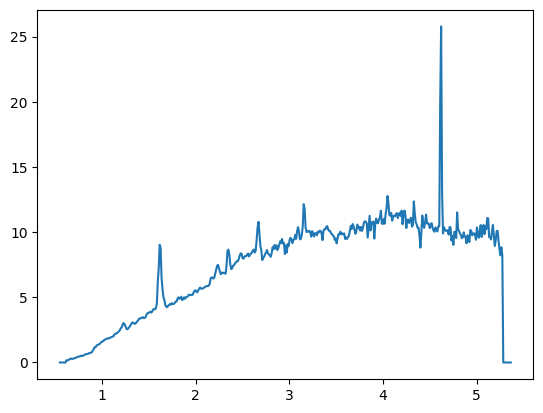

In [8]:
import matplotlib.pyplot as plt

plt.plot(test.spec_wobs,test.spec_fnu)